# S2: All cells QC

In [1]:
from notebook_utils import *

# print modules and versions            
imports()

/home/ubuntu/py_36_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/ubuntu/py_36_env/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


pandas: 1.0.3
numpy: 1.18.2
scanpy.api: 1.4.4.post1
anndata: 0.6.22rc1
plotnine: 0.6.0
scipy: 1.4.1
more_itertools: 8.2.0
tqdm: 4.45.0
sklearn: 0.22.2.post1
lifelines: 0.24.3
matplotlib: 3.0.3


In [2]:
# settings
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data'

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv(f'{wkdir}/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# read fetal supp data
pre_adata_supp1 = (pd.read_csv(f'{wkdir}/DL20190319_fetal_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# read adult supp data
pre_adata_supp2 = (pd.read_csv(f'{wkdir}/DL20190417_adult_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# merge with raw
pre_adata = pd.concat([pre_adata, pre_adata_supp1,pre_adata_supp2], axis=1)
cell_names = pre_adata.columns.tolist()

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv(f'{wkdir}/DL20190417_mel_metadata.csv')
meta_df = meta_df.drop(['GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), meta_df, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')



/home/ubuntu/py_36_env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/py_36_env/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


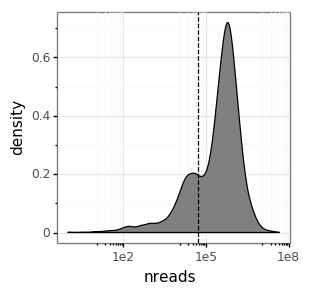

<ggplot: (-9223363297808479018)>


/home/ubuntu/py_36_env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/py_36_env/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


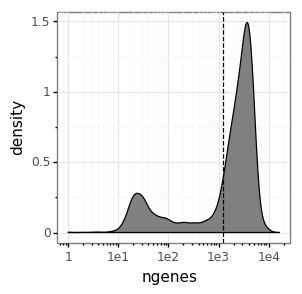

<ggplot: (-9223363297808308287)>


/home/ubuntu/py_36_env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ubuntu/py_36_env/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 1145 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


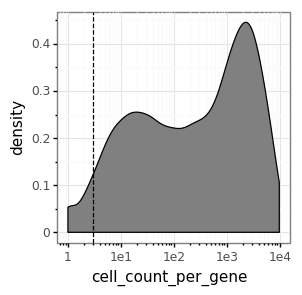

<ggplot: (8739052343735)>


In [3]:
# nreads
dist_df = pd.DataFrame({'nreads':pre_adata.astype(int).sum().values,
                        'ngenes':(pre_adata > 0).sum().values,
                        'cell_id':pre_adata.columns
                       }).set_index('cell_id')
plotnine.options.figure_size = (3,3)

plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('nreads'), fill='grey')
        + geom_vline(aes(xintercept=50000), linetype='--')
        + scale_x_log10()
       )
print(plot)

# ngenes
plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('ngenes'), fill='grey')
        + geom_vline(aes(xintercept=1250), linetype='--')
        + scale_x_log10()
       )
print(plot)

passing_cells = (dist_df
                 .query('nreads >= 50000')
                 .query('ngenes >= 1250')
                 .reset_index()['cell_id']
                 .tolist()
                )
filtered_pre_adata = pre_adata.loc[:, passing_cells]
dist_df2 = pd.DataFrame({'cell_count_per_gene':(filtered_pre_adata > 0).sum(axis=1)
                       })

# n cells per gene
plot = (ggplot(dist_df2)
        + theme_bw()
        + geom_density(aes('cell_count_per_gene'), fill='grey')
        + geom_vline(aes(xintercept=3), linetype='--')
        + scale_x_log10()
       )
print(plot)

### SRA upload

In [3]:
# source_dict = {'10WK03':'Laurence Baskin',
#              '12WK05':'Laurence Baskin',
#              '12WKM01':'Laurence Baskin',
#              '16WKM04':'Laurence Baskin',
#              '18WKM06':'Laurence Baskin',
#              '9.5WK02':'Laurence Baskin',
#              'A1011L':'Aaron D. Tward',
#              'A1012M':'Aaron D. Tward',
#              'A1014L':'Scott VandenBerg (UCSF BIOS)',
#              'A1015LM':'Aaron D. Tward',
#              'A1016LM':'Scott VandenBerg (UCSF BIOS)',
#              'A1017LM':'Scott VandenBerg (UCSF BIOS)',
#              'A1020LM':'Aaron D. Tward',
#              'A1021M':'Scott VandenBerg (UCSF BIOS)',
#              'A1022M':'Aaron D. Tward',
#              'A1025L':'Scott VandenBerg (UCSF BIOS)',
#              'A1026L':'Scott VandenBerg (UCSF BIOS)',
#              'A1033M':'Scott VandenBerg (UCSF BIOS)',
#              'A1038LM':'Scott VandenBerg (UCSF BIOS)',
#              'A1046M':'Scott VandenBerg (UCSF BIOS)',
#              'FS030_LM':'Thea Mauro',
#              'FS043_LM':'Thea Mauro',}


In [6]:
# # biosample attributes TSV
# biosampledf = (merged_anno
#                .loc[:,['patient_id','age','sex']]
#                .reset_index()
#                .rename(columns={'cell_name':'sample_name',
#                                 'patient_id':'isolate'
#                                })
#               )
# biosampledf['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 \
#                       else np.nan \
#                       for x in biosampledf.isolate]
# biosampledf['age'] = [y+(9/12) if np.isnan(x) \
#                       else x \
#                       for x,y in zip(biosampledf['true_year'], 
#                                      biosampledf['age'])]
# biosampledf['age'] = [f'{x} yr' for x in biosampledf['age'].round(2)]
# biosampledf = biosampledf.drop('true_year', axis = 1)
# biosampledf['biomaterial_provider'] = [source_dict.get(x) for x in biosampledf['isolate']]
# biosampledf['organism'] = 'Homo sapiens'
# biosampledf['tissue'] = 'Skin'
# biosampledf = biosampledf.loc[:, ['sample_name',
#                                   'organism',
#                                   'isolate',
#                                   'age',
#                                   'biomaterial_provider',
#                                   'sex',
#                                   'tissue',
#                                  ]
#                              ]
# biosampledf['sex'] = biosampledf['sex'].replace('Ukn','Unknown')


# # minimal biosample matrix
# mini_biosampledf = (biosampledf
#                     .loc[:, ['organism',
#                               'isolate',
#                               'age',
#                               'biomaterial_provider',
#                               'sex',
#                               'tissue',]]
#                     .drop_duplicates()
#                    )
# mini_biosampledf['sample_name'] = mini_biosampledf['isolate'].values
# sample2isolate = {'10WK03':'fetus, 10 wk, i03',
#              '12WK05':'fetus, i05',
#              '12WKM01':'fetus, iM01',
#              '16WKM04':'fetus, iM04',
#              '18WKM06':'fetus, iM06',
#              '9.5WK02':'fetus, i02',
#              'A1011L':'adult, i1011',
#              'A1012M':'adult, i1012',
#              'A1014L':'adult, i1014',
#              'A1015LM':'adult, i1015',
#              'A1016LM':'adult, i1016',
#              'A1017LM':'adult, i1017',
#              'A1020LM':'adult, i1020',
#              'A1021M':'adult, i1021',
#              'A1022M':'adult, i1022',
#              'A1025L':'adult, i1025',
#              'A1026L':'adult, i1026',
#              'A1033M':'adult, i1033',
#              'A1038LM':'adult, i1038',
#              'A1046M':'adult, i1046',
#              'FS030_LM':'neonate, i030',
#              'FS043_LM':'neonate, i043',
#                  }

# mini_biosampledf['isolate'] = [sample2isolate.get(x) for x in mini_biosampledf['sample_name']]
# mini_biosampledf = mini_biosampledf.loc[:, ['sample_name',
#                                   'organism',
#                                   'isolate',
#                                   'age',
#                                   'biomaterial_provider',
#                                   'sex',
#                                   'tissue',
#                                  ]
#                              ]
# mini_biosampledf.to_csv(f'/home/ubuntu/s3_dump/biosample_mini.tsv', 
#                    index=False,
#                    sep='\t'
#                   )
# mini_biosampledf

In [7]:
# # create patient-specific bam list to be merged
# for patient_val in set(biosampledf.isolate):
#     bam_dir = '/home/ubuntu/s3_dump/bams'
#     outbamlist = f'/home/ubuntu/s3_dump/merged_aux/{patient_val}.txt'

#     with open(outbamlist, 'w') as outf:
#         for idx, cell_id in enumerate(biosampledf.query(f'isolate == "{patient_val}"')['sample_name']):
#             inbam = f'{bam_dir}/{cell_id}.bam'
#             outf.write(inbam + '\n')

# # create patient-specific header
# for patient_val in set(biosampledf.isolate):
#     out_dir = '/home/ubuntu/s3_dump/merged_aux'
#     out_fn = f'{out_dir}/{patient_val}.header'
#     with open(out_fn, 'w') as outf:
        
#         ### create base header with samtools ###
#         input_header_fn = '/home/ubuntu/s3_dump/base.header'
#         with open(input_header_fn, 'r') as base_header:
#             for line in base_header:
#                 if line.startswith('@PG') or line.startswith('@CO'):
#                     pass
#                 else:
#                     outf.write(line)
                
#             for idx, cell_id in enumerate(biosampledf.query(f'isolate == "{patient_val}"')['sample_name']):
#                 outf.write('@RG' + '\t' + f'ID:{cell_id}' + '\n')

In [8]:
# # metadata tsv
# md5_output = '/home/ubuntu/s3_dump/merged_bams//files.md5'
# md5_df = pd.read_csv(md5_output, sep ='  ', header=None)
# md5_df.columns=['MD5_checksum','filename']

# md5_df['sample_name'] = [x.split('.rehead.bam')[0] for x in md5_df['filename']]
# md5_df['library_ID'] = md5_df['sample_name'].values
# md5_df['filetype'] = 'bam'
# md5_df['assembly'] = 'hg38'
# md5_df['design_description'] = 'smart-seq2'
# md5_df['instrument_model'] = 'Illumina NovaSeq 6000'
# md5_df['platform'] = 'ILLUMINA'
# md5_df['library_layout'] = 'paired'
# md5_df['library_selection'] = 'other'
# md5_df['library_source'] = 'TRANSCRIPTOMIC'
# md5_df['library_strategy'] = 'RNA-Seq'
# md5_df['title'] = 'single-cell RNAseq of human melanocytes'

# #### TBD####
# md5_df['biosample_accession'] = ''
# md5_df['bioproject_accession'] = ''
# #### TBD####

# md5_df = md5_df.loc[:, ['bioproject_accession',
#                         'biosample_accession',
#                         'sample_name',
#                         'library_ID',
#                         'title',
#                         'library_strategy',
#                         'library_source',
#                         'library_selection',
#                         'library_layout',
#                         'platform',
#                         'instrument_model',
#                         'design_description',
#                         'assembly',
#                         'filetype',
#                         'filename',
#                         'MD5_checksum',]]
# # starts, ends = create_ranges(len(md5_df), 1000)
# # for start,end in zip(starts, ends):
# #     print(start, end)
# #     (md5_df
# #      .iloc[start:end,:]
# #      .to_csv(f'/home/ubuntu/s3_dump/SRA_metadata_{start}-{end}.tsv', 
# #                    index=False,
# #                    sep='\t',
# #                   )
# #     )
# md5_df.to_csv(f'/home/ubuntu/s3_dump/SRA_metadata.tsv', 
#                    index=False,
#                    sep='\t',
#                   )
# md5_df

In [ ]:
# bam_dir = '/home/ubuntu/s3_dump/bams'
# input_header_fn = '/home/ubuntu/s3_dump/trimmed_header.txt'

# # create complete header
# for patient_val in set(biosampledf.isolate):
#     bam_dir = '/home/ubuntu/s3_dump/bams'
#     header_fn = f'/home/ubuntu/s3_dump/merged_bams/{patient_val}.header'
    
#     with open(header_fn, 'w') as outf:
#         with open(input_header_fn, 'r') as header_text:
#             for line in header_text:
#                 outf.write(line)
                
#             for idx, cell_id in enumerate(biosampledf.query(f'isolate == "{patient_val}"')['sample_name']):
#                 outf.write('@RG' + '\t' + f'ID:{cell_id}' + '\n')
